In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import pyrsm as rsm
from random import random, gauss, seed

### - Null hypothesis (H0): There is no difference in outcomes (open rate, click rate, donation transactions, total donation amount) between the control and treatment groups. 
### - Alternative hypothesis (H1): There is a difference in outcomes between the control and treatment groups.

### Overview Data Input

In [2]:
control_group = {'recipients': 2715, 'opened': 1388, 'clicked': 28, 'donations': 22, 'total_amount': 569.03}
treatment_group = {'recipients': 2714, 'opened': 1365, 'clicked': 21, 'donations': 3, 'total_amount': 21.20}


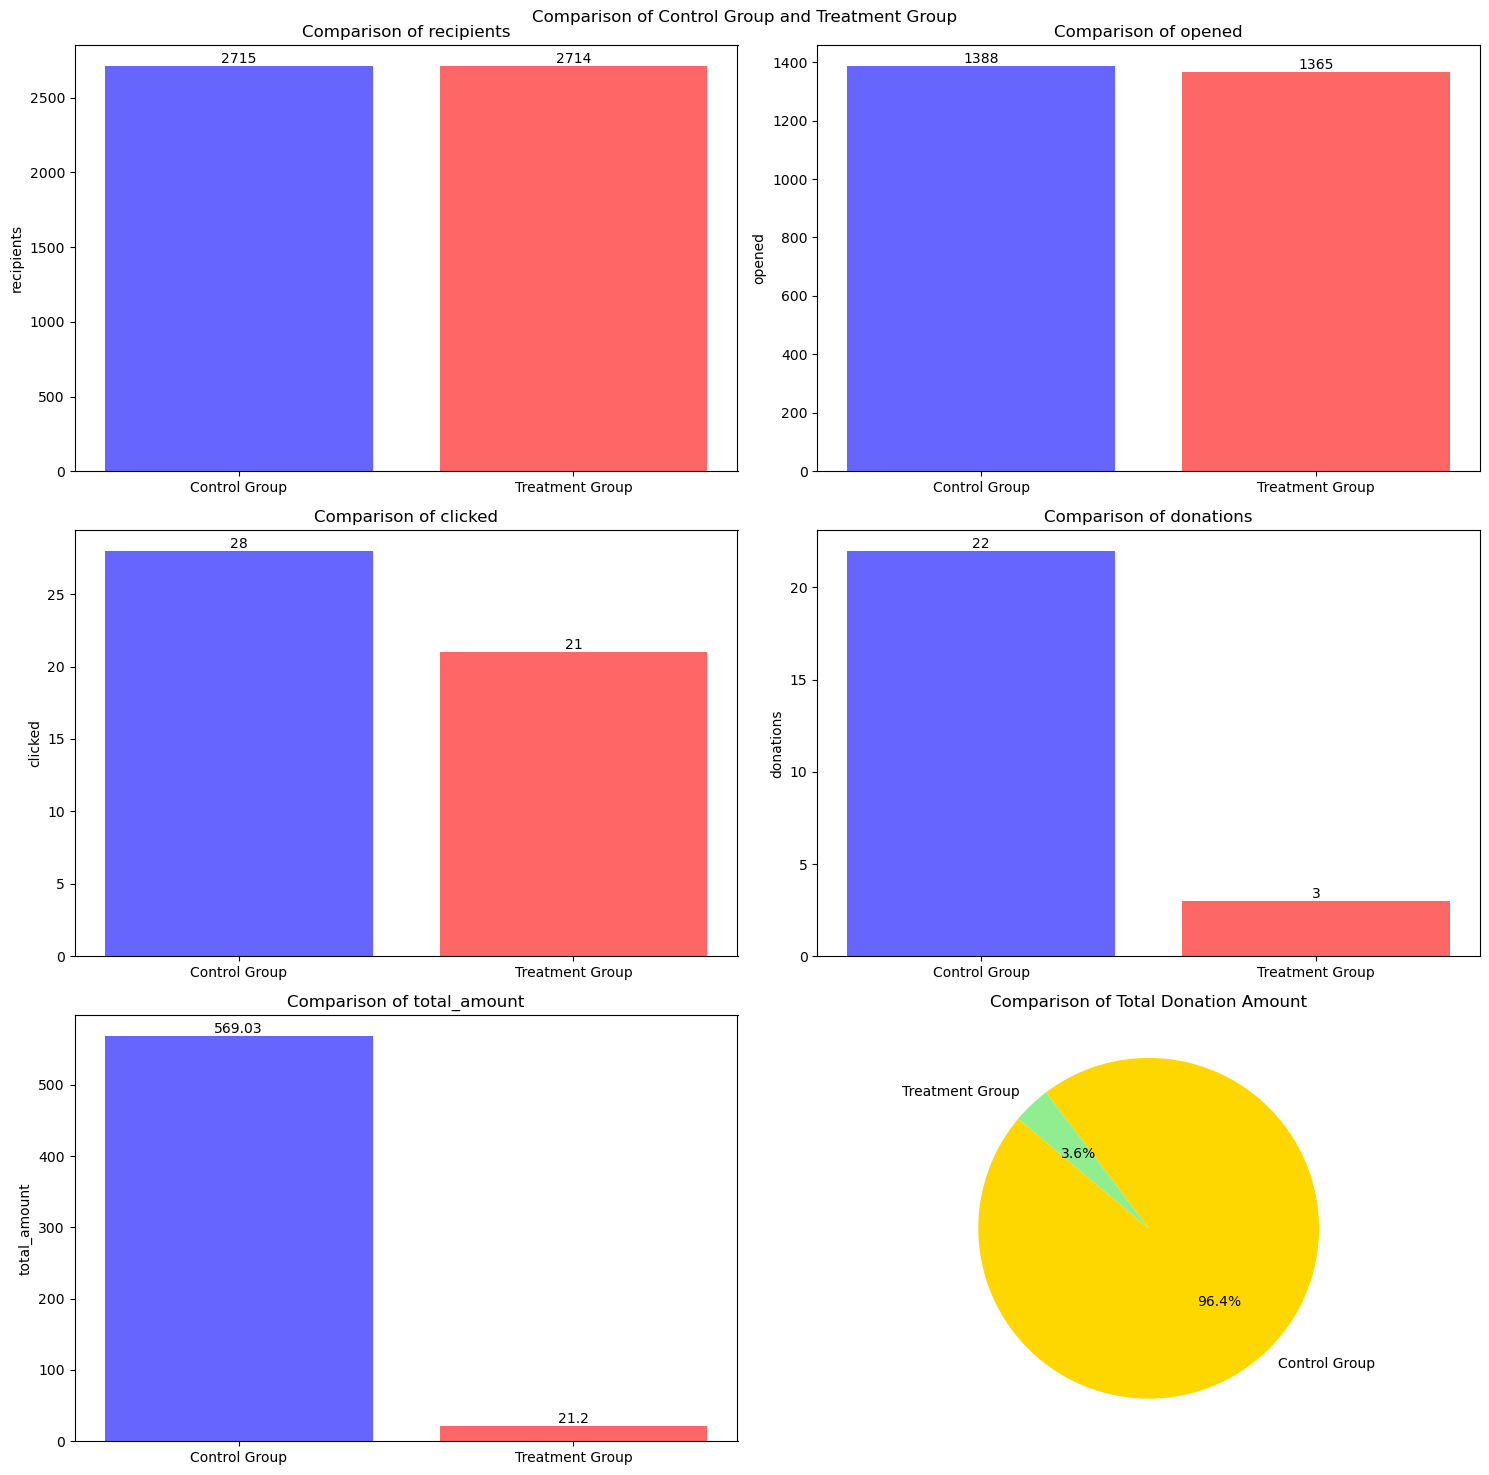

In [3]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  

metrics = ['recipients', 'opened', 'clicked', 'donations', 'total_amount']

for i, ax in enumerate(axs.flat):
    if i < len(metrics):  
        metric = metrics[i]
        bars1 = ax.bar('Control Group', control_group[metric], color='b', alpha=0.6)
        bars2 = ax.bar('Treatment Group', treatment_group[metric], color='r', alpha=0.6)

        ax.text(bars1[0].get_x() + bars1[0].get_width() / 2, bars1[0].get_height(), str(control_group[metric]), 
            ha='center', va='bottom')
        ax.text(bars2[0].get_x() + bars2[0].get_width() / 2, bars2[0].get_height(), str(treatment_group[metric]), 
            ha='center', va='bottom')

        ax.set_ylabel(metric)
        ax.set_title(f'Comparison of {metric}')
    elif i == len(metrics): 
        wedges, texts, autotexts = ax.pie([control_group['total_amount'], treatment_group['total_amount']],
               labels=['Control Group', 'Treatment Group'], autopct='%1.1f%%',
               colors=['gold', 'lightgreen'], startangle=140)  
        ax.set_title('Comparison of Total Donation Amount')
        
        for autotext in autotexts:
            autotext.set_color('black')

fig.suptitle('Comparison of Control Group and Treatment Group')

plt.tight_layout()
plt.show()

#### Recipients: The control group and the treatment group were almost identical in size, with 2715 and 2714 recipients respectively. This ensures a fair comparison between the two groups.

#### Opened: The control group had a slightly higher open rate than the treatment group, with 1388 opens compared to 1365. This suggests that the control group's email might have been slightly more appealing or noticeable.

#### Clicked: The control group also had a higher click rate, with 28 clicks compared to the treatment group's 21. This could indicate that the content or call-to-action in the control group's email was more engaging.

#### Donations: The control group had significantly more donations than the treatment group, with 22 donations compared to just 3. This is a strong indication that the control group's email was more effective at encouraging donations.

#### Total Amount: The control group also raised significantly more money, with a total donation amount of $569.03 compared to the treatment group's $21.20. This further supports the conclusion that the control group's email was more effective.

#### In conclusion, the data suggests that there is a significant difference in outcomes between the control and treatment groups, with the control group performing better in all measured outcomes. Therefore, we would reject the null hypothesis (H0) and accept the alternative hypothesis (H1). However, further statistical tests could be performed to confirm these findings.

### Donation Data Input 

(spreadsheet data is available, however, I will manually enter each record for the sake of convenience and reproducibility, with the assistance of AI)

In [12]:
# Your raw data copied into a multi-line string.
raw_data = """
2/14/24 8:30:19 USD $25.00 ($0.99) $24.01 4RJ50238LH3273201 Control 24.01
2/14/24 8:32:55 USD $5.00 ($0.59) $4.41 1CS29938DH352383F Control 28.42
2/14/24 8:36:35 USD $26.01 ($1.01) $25.00 609021870A869074U Control 53.42
2/14/24 8:45:47 USD $10.00 ($0.69) $9.31 4P8346689E003973T Treatment 62.73
2/14/24 8:45:58 USD $26.01 ($1.01) $25.00 9LU06069TC675342D Control 87.73
2/14/24 8:46:04 USD $10.70 ($0.70) $10.00 81R64769K0952892W Control 97.73
2/14/24 8:47:13 USD $10.00 ($0.69) $9.31 4DG447728E282094U Control 107.04
2/14/24 8:48:10 USD $5.60 ($0.60) $5.00 8AB80657V08651504 Control 112.04
2/14/24 9:27:36 USD $10.70 ($0.70) $10.00 8AE79323U6595050M Control 122.04
2/14/24 9:30:16 USD $10.00 ($0.69) $9.31 9DG72001GK270803E Control 131.35
2/14/24 9:53:07 USD $5.00 ($0.59) $4.41 32T338822P9226721 Control 135.76
2/14/24 11:10:28 USD $5.60 ($0.60) $5.00 9M208951BX749030S Treatment 140.76
2/14/24 12:33:40 USD $5.60 ($0.60) $5.00 8RG49088CM6992841 Treatment 145.76
2/15/24 12:29:52 USD $10.70 ($0.70) $10.00 8V606976SD056232T Control 155.76
2/20/24 7:41:25 USD $100.00 ($2.48) $97.52 6WD93967C95215209 Control 253.28
2/21/24 8:32:42 USD $10.70 ($0.70) $10.00 0DD54248ES851703R Control 263.28
2/21/24 9:50:30 USD $26.01 ($1.01) $25.00 2V463138MJ382361D Control 288.28
2/21/24 10:11:58 USD $10.70 ($0.70) $10.00 92N95163RW223922F Control 298.28
2/21/24 10:34:05 USD $100.00 ($2.48) $97.52 7US90780MF5652711 Control 395.8
2/21/24 13:02:54 USD $50.00 ($1.49) $48.51 8B641727M62052643 Control 444.31
2/21/24 13:05:21 USD $5.60 ($0.60) $5.00 2D934628RS071621C Control 449.31
2/21/24 17:43:05 USD $10.70 ($0.70) $10.00 45D62063TM374945P Control 459.31
2/21/24 19:19:47 USD $100.00 ($2.48) $97.52 5RY89178MS707940X Control 556.83
2/21/24 20:35:32 USD $5.00 ($0.59) $4.41 7H6371176T898371T Control 561.24
2/23/24 7:35:08 USD $5.60 ($0.60) $5.00 2T926879T6579761E Control 566.24
"""

# Splitting the raw data into lines and then fields to create a list of lists
data_list = [line.split() for line in raw_data.strip().split('\n')]

# Convert the nested lists into a proper format for a DataFrame
formatted_data = [
    [' '.join(row[:2])] + row[2:4] + 
    [row[4].replace('$', '')] + 
    [row[5].replace('($', '').replace(')', '')] + 
    [row[6].replace('$', '')] + 
    row[7:] 
    for row in data_list
]

columns = [
    "date_time", "currency", "gross", "fee", "net",
    "transaction_id", "group", "balance"
]

donation = pd.DataFrame(formatted_data, columns=columns)



donation






,date_time,currency,gross,fee,net,transaction_id,group,balance
0,2/14/24 8:30:19,USD,$25.00,(0.99),$24.01,4RJ50238LH3273201,Control,24.01
1,2/14/24 8:32:55,USD,$5.00,(0.59),$4.41,1CS29938DH352383F,Control,28.42
2,2/14/24 8:36:35,USD,$26.01,(1.01),$25.00,609021870A869074U,Control,53.42
3,2/14/24 8:45:47,USD,$10.00,(0.69),$9.31,4P8346689E003973T,Treatment,62.73
4,2/14/24 8:45:58,USD,$26.01,(1.01),$25.00,9LU06069TC675342D,Control,87.73
5,2/14/24 8:46:04,USD,$10.70,(0.70),$10.00,81R64769K0952892W,Control,97.73
6,2/14/24 8:47:13,USD,$10.00,(0.69),$9.31,4DG447728E282094U,Control,107.04
7,2/14/24 8:48:10,USD,$5.60,(0.60),$5.00,8AB80657V08651504,Control,112.04
8,2/14/24 9:27:36,USD,$10.70,(0.70),$10.00,8AE79323U6595050M,Control,122.04
9,2/14/24 9:30:16,USD,$10.00,(0.69),$9.31,9DG72001GK270803E,Control,131.35


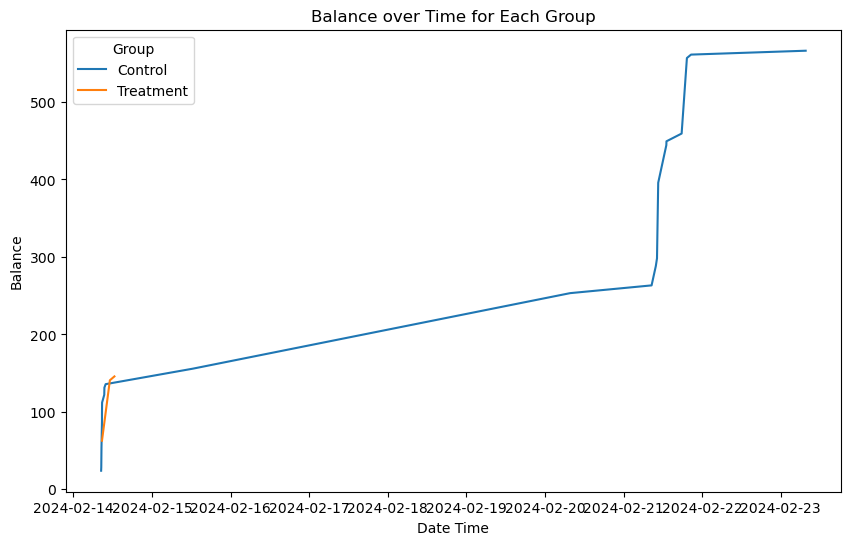

In [31]:
# Convert 'date_time' to datetime
donation['date_time'] = pd.to_datetime(donation['date_time'])
# Remove dollar signs and convert 'net' and 'balance' to float
donation['net'] = donation['net'].replace('[\$,]', '', regex=True).astype(float)
donation['balance'] = donation['balance'].replace('[\$,]', '', regex=True).astype(float)

# Plot
plt.figure(figsize=(10,6))
for group in donation['group'].unique():
    plt.plot(donation[donation['group'] == group]['date_time'], donation[donation['group'] == group]['balance'], label=group)
plt.xlabel('Date Time')
plt.ylabel('Balance')
plt.title('Balance over Time for Each Group')
plt.legend(title='Group')
plt.show()

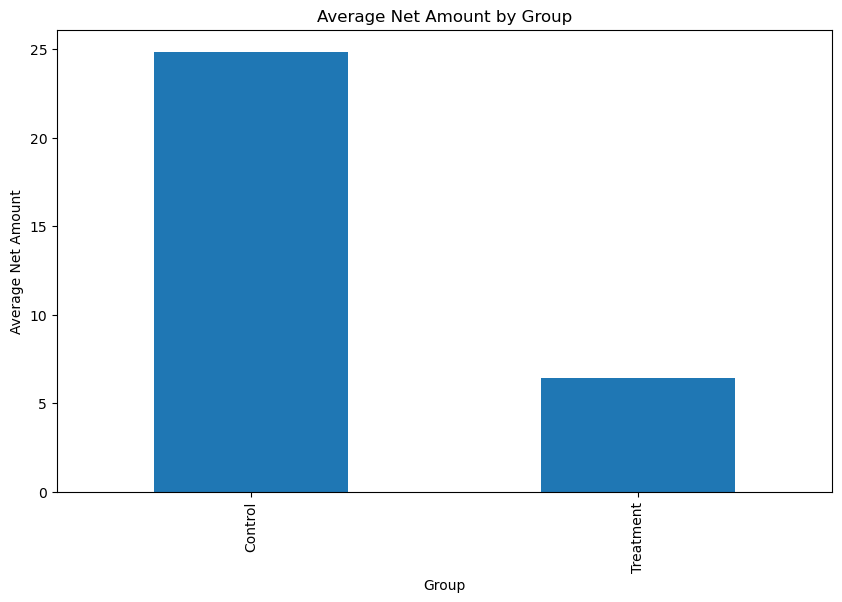

In [14]:
# Convert 'net' to float
donation['net'] = donation['net'].astype(float)

# Group by 'group' and calculate mean 'net'
group_net = donation.groupby('group')['net'].mean()

# Plot
group_net.plot(kind='bar', figsize=(10,6))
plt.xlabel('Group')
plt.ylabel('Average Net Amount')
plt.title('Average Net Amount by Group')
plt.show()

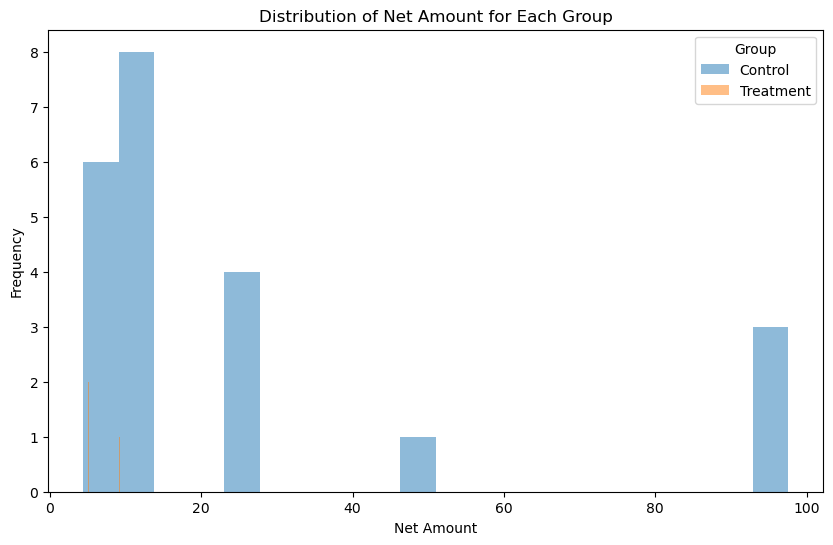

In [30]:
# Plot
plt.figure(figsize=(10,6))
for group in donation['group'].unique():
    plt.hist(donation[donation['group'] == group]['net'], bins=20, alpha=0.5, label=group)
plt.xlabel('Net Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Net Amount for Each Group')
plt.legend(title='Group')
plt.show()

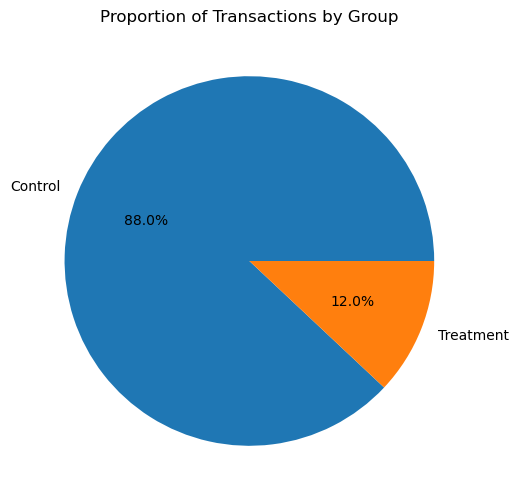

In [18]:
# Calculate the number of transactions in each group
group_counts = donation['group'].value_counts()

# Plot
plt.figure(figsize=(10,6))
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%')
plt.title('Proportion of Transactions by Group')
plt.show()

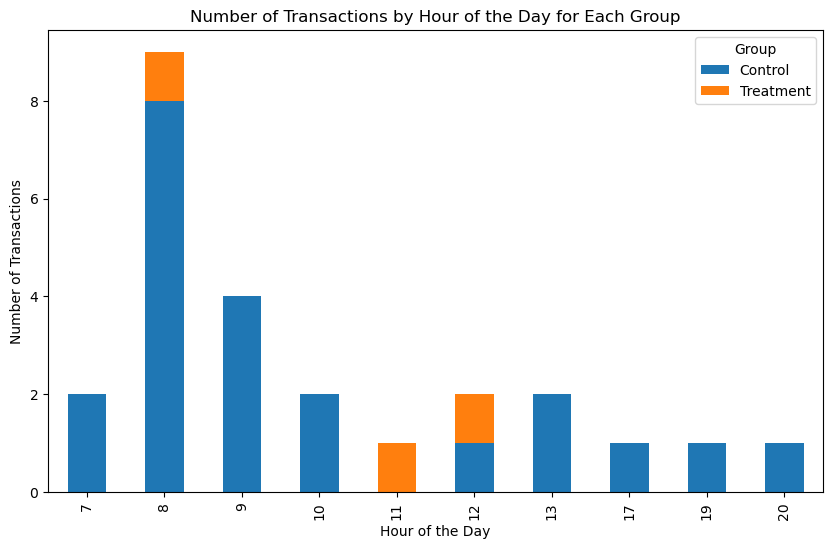

In [29]:
# Count the number of transactions per hour for each group
hourly_transactions_group = donation.groupby(['hour', 'group'])['group'].count().unstack()

# Plot
hourly_transactions_group.plot(kind='bar', stacked=True, figsize=(10,6))
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Hour of the Day for Each Group')
plt.legend(title='Group')
plt.show()

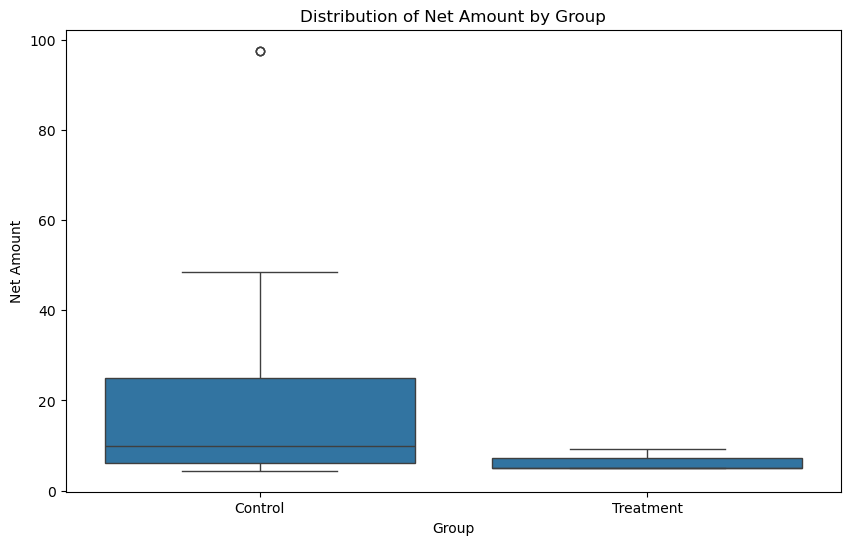

In [23]:
# Plot
plt.figure(figsize=(10,6))
sns.boxplot(x='group', y='net', data=donation)
plt.xlabel('Group')
plt.ylabel('Net Amount')
plt.title('Distribution of Net Amount by Group')
plt.show()

#### - for predicting whether or not someone will make a donation (a binary outcome), logistic regression should be conducted. This model will let you understand the likelihood of a donation occurring based on independent variables, such as being in the treatment or control group.

### Logistic Regression to predict the Group with Higher Clicks or Donations Rates

#### To build a model like Logistic Regression, we will need a larger data than 24 rows data. we can simulate to create an entire data based on the factual information as given below. 

control_group = {'recipients': 2715, 'opened': 1388, 'clicked': 28, 'donations': 22, 'total_amount': 569.03}
treatment_group = {'recipients': 2714, 'opened': 1365, 'clicked': 21, 'donations': 3, 'total_amount': 21.20}

In [80]:
# Updated simulation to match exact statistics
np.random.seed(42)  # For reproducibility

# Define the parameters for the simulation based on provided data
params = {
    'control': {
        'recipients': 2715, 
        'opened': 1388, 
        'clicked': 28, 
        'donations': 22, 
        'total_amount': 569.03
    },
    'treatment': {
        'recipients': 2714, 
        'opened': 1365, 
        'clicked': 21, 
        'donations': 3, 
        'total_amount': 21.20
    }
}

# Function to distribute values based on provided counts
def distribute_values(count, total_recipients):
    values = [1] * count + [0] * (total_recipients - count)
    np.random.shuffle(values)
    return values

# Initialize an empty list to store the simulated data
simulated_data = []

# Simulate the data for each group
for group, group_params in params.items():
    # Distribute opened, clicked, and donations
    opened_values = distribute_values(group_params['opened'], group_params['recipients'])
    clicked_values = distribute_values(group_params['clicked'], group_params['recipients'])
    donations_values = distribute_values(group_params['donations'], group_params['recipients'])
    
    # Calculate individual donation amounts for those who donated
    donation_amounts = [0] * group_params['recipients']
    if group_params['donations'] > 0:
        individual_donation_amount = group_params['total_amount'] / group_params['donations']
        donation_amounts = [individual_donation_amount if x else 0 for x in donations_values]
    
    # Create data for each recipient
    for i in range(group_params['recipients']):
        simulated_data.append([group, opened_values[i], clicked_values[i], donations_values[i], donation_amounts[i]])

# Define the columns for the DataFrame
columns = ['group', 'opened', 'clicked', 'donations', 'total_amount']

# Create the DataFrame
simulated_df = pd.DataFrame(simulated_data, columns=columns)

# Verify the totals match the provided statistics
verification = {
    'control': simulated_df[simulated_df['group'] == 'control'].sum(),
    'treatment': simulated_df[simulated_df['group'] == 'treatment'].sum()
}

simulated_df['group'] = simulated_df['group'].map({'control': 1, 'treatment': 0})

simulated_df['group'] = simulated_df['group'].astype('category')
simulated_df['opened'] = simulated_df['opened'].astype('category')
simulated_df['clicked'] = simulated_df['clicked'].astype('category')
simulated_df['donations'] = simulated_df['donations'].astype('category')

simulated_df


,group,opened,clicked,donations,total_amount
0,1,1,0,0,0.0
1,1,0,0,0,0.0
2,1,0,0,0,0.0
3,1,1,0,0,0.0
4,1,0,0,0,0.0
...,...,...,...,...,...
5424,0,1,0,0,0.0
5425,0,0,0,0,0.0
5426,0,1,0,0,0.0
5427,0,1,0,0,0.0


### - Predicting whether or not someone will make a donation (a binary outcome), logistic regression is the right choice. This model will let you understand the likelihood of a donation occurring based on independent variables, such as being in the treatment or control group.

In [85]:
# Adding a new column 'training' to the final_data with random 1 and 0 assigned in a 70:30 ratio
np.random.seed(42)  # For reproducibility
simulated_df['training'] = np.random.choice([1, 0], size=len(simulated_df), p=[0.7, 0.3])

# Checking the distribution of the 'training' column to ensure it's approximately 70:30
training_distribution = simulated_df['training'].value_counts(normalize=True)
training_distribution


training
1    0.70676
0    0.29324
Name: proportion, dtype: float64

In [88]:
simulated_df_train = simulated_df[simulated_df['training'] == 1]

lr = rsm.model.logistic(
    data = simulated_df_train,
    rvar = 'group',
    evar = ['opened', 'clicked', 'donations', 'total_amount']
)

lr.summary()

Logistic regression (GLM)
Data                 : Not provided
Response variable    : group
Level                : None
Explanatory variables: opened, clicked, donations, total_amount
Null hyp.: There is no effect of x on group
Alt. hyp.: There is an effect of x on group

                        OR                     OR%  coefficient  std.error  z.value p.value   
Intercept     1.062000e+00                    6.2%         0.06      0.046    1.303   0.193   
opened[1]     9.210000e-01                   -7.9%        -0.08      0.065   -1.275   0.202   
clicked[1]    7.650000e-01                  -23.5%        -0.27      0.358   -0.747   0.455   
donations[1]  8.330097e+17  8.330097367752958e+19%        41.26  77599.123    0.001     1.0   
total_amount  8.200000e-02                  -91.8%        -2.51   3149.413   -0.001   0.999   

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squared (McFadden): 0.006
Pseudo R-squared (McFadden adjusted): 0.004
Area under the

lr = rsm.model.logistic(
    data = donation,
    rvar = 'group',
    evar = []
)

lr.summary()

In [96]:
# Train the mlp model on the treatment data
mlp = rsm.model.mlp(
    data = simulated_df_train,
    rvar = 'group',
    evar = ['opened', 'clicked', 'donations', 'total_amount'],
    hidden_layer_sizes = (5, 5),
    mod_type = "classification"
)

mlp.summary()

Multi-layer Perceptron (NN)
Data                 : Not provided
Response variable    : group
Level                : None
Explanatory variables: opened, clicked, donations, total_amount
Model type           : classification
Nr. of features      : (4, 4)
Nr. of observations  : 3,837
Hidden_layer_sizes   : (5, 5)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 10000
random_state         : 1234
AUC                  : 0.517

Raw data             :
opened clicked donations  total_amount
     1       0         0           0.0
     1       0         0           0.0
     0       0         0           0.0
     1       0         0           0.0
     1       0         0           0.0

Estimation data      :
 total_amount  opened_1  clicked_1  donations_1
    -0.070455      True      False        False
    -0.070455      True      False        False
    -0.070455     False      Fal

In [97]:
rf = rsm.model.rforest(
    data = simulated_df_train,
    rvar = 'group',
    evar = ['opened', 'clicked', 'donations', 'total_amount'],
    n_estimators = 200,
    max_features = 5,
    mod_type = "classification"
)

rf.summary()

Random Forest
Data                 : Not provided
Response variable    : group
Level                : None
Explanatory variables: opened, clicked, donations, total_amount
OOB                  : True
Model type           : classification
Nr. of features      : (4, 4)
Nr. of observations  : 3,837
max_features         : 5 (5)
n_estimators         : 200
min_samples_leaf     : 1
random_state         : 1234
AUC                  : 0.552

Estimation data      :
 total_amount  opened_1  clicked_1  donations_1
          0.0      True      False        False
          0.0      True      False        False
          0.0     False      False        False
          0.0      True      False        False
          0.0      True      False        False
